# Построение ML модели на основе анализа поведения пользователей мобильного оператора

## Описание проекта

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Необходимо построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

Модель должна иметь как можно большее значение accuracy.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

> сalls — количество звонков<br>
> minutes — суммарная длительность звонков в минутах<br>
> messages — количество sms-сообщений<br>
> mb_used — израсходованный интернет-трафик в Мб<br>
> is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)<br>

## Общая информация о файле и его структура <a class="anchor" id="second-bullet"></a>

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier

У нас имеется один файл формата csv, откроем его, и ознакомимся со структурой файла, а также получим общую информацию о файле с помощью функции.

In [4]:
def load_df(name_of_df, separator=",", ind=None):
    """Функция загружает датафрэйм и выводит основные данные по нему.
    Аргументы:
    name_of_df - путь к датафрэйму;
    separator - разделитель;
    ind - столбцы для использования в качестве номеров строк"""

    # Считаем и выведем первые 5 строк таблицы
    df = pd.read_csv(name_of_df, sep=separator, index_col=ind)
    print("Выведем первые 5 строк таблицы:", end="\n\n")
    display(df.head())

    # Вывод основных описательных статистик, общей информации о таблице,
    # пропущенных значений, корреляции признаков, количества дубликатов в данных
    print(
        "\n\n\n\nОтобразим основные описательные статистики по признакам:", end="\n\n"
    )
    display(df.describe())
    print("\n\n\n\nПолучим общую информацию о таблице:", end="\n\n")
    display(df.info())
    print(f"\n\n\n\nПропущенные значения по признакам:", end="\n\n")
    display(pd.DataFrame(df.isnull().sum(), columns=["missing_values"]))
    print(f"\n\n\n\nКорреляция признаков:", end="\n\n")
    display(df.corr())
    return df

In [5]:
users_behavior = load_df("users_behavior.csv")

Выведем первые 5 строк таблицы:



,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0






Отобразим основные описательные статистики по признакам:



,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000






Получим общую информацию о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None





Пропущенные значения по признакам:



,missing_values
calls,0
minutes,0
messages,0
mb_used,0
is_ultra,0






Корреляция признаков:



,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


### Вывод

В файле "users_behavior.csv" имеется 3 214 строк (объектов) и 5 столбцов (признаков). Для задач машинного обучения будет справедливо назвать датафрэйм матрицей признаков. Пропущенные значения в таблице отсутствуют, т.к. предобработка данных уже выполнена.

## Разбиение на выборки

Для начала необходимо раздлелить выборку на обучающую и валидационную выборки. У нас имеется один датасэт и нет спрятанной тестовой выборки, следовательно, необходимо делить на 3 выборки: обучающая (60% от исходного датасэта), валидационная выборка (20% от исходного датасэта), тестовая выборка (20% от исходного датасэта). Разбиение рекомендуется выполнять со следующим соотношением:

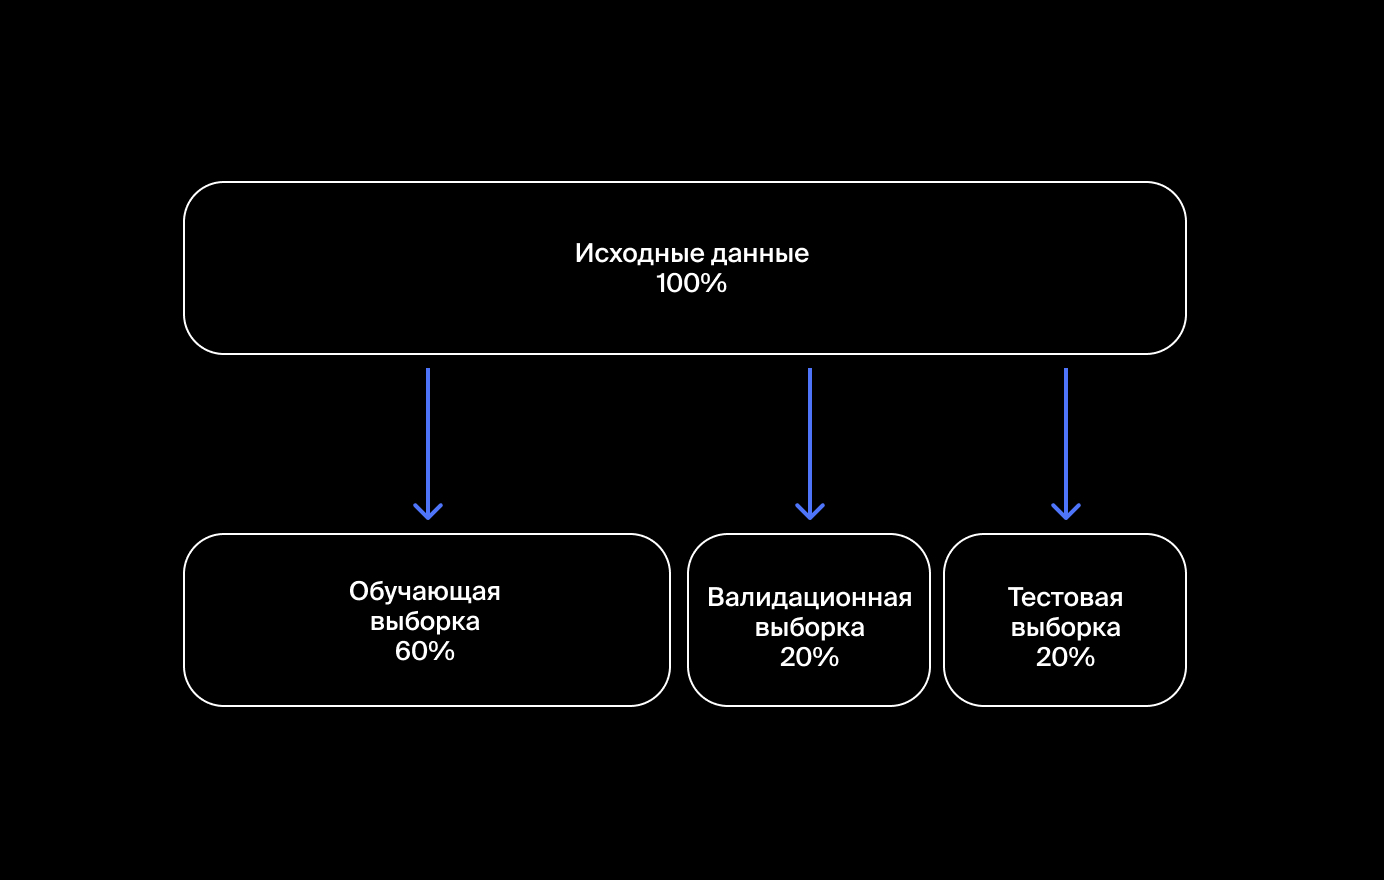

Для реализации этого можно разделить весь датасэт с помощью функции train_test_split на train split и test split, передав в качестве параметра test_size=.2 (20% от исходной выборки сохраним в качестве тестовой выборки. После чего снова поделим test split, чтобы поделить тестовую выборку на тестовую и валидационную, передав в качестве параметра test_size=.25 (0.25 x 0.8 = 0.2, таким образом 20% от исходной выборки сохраним для валидационного датасэта, а 60% останется для обучения).

Однако, можно пойти более простым и эффективным путем, используя функцию cross_val_score, с помощью которой мы сможем выполнить кросс-валидацию, а также использование функции GridSearchCV, которая поможет подобрать наилучшие параметры для модели, а также поддерживает кросс-валидацию. Схема кросс-валидации выглядит следующим образом:

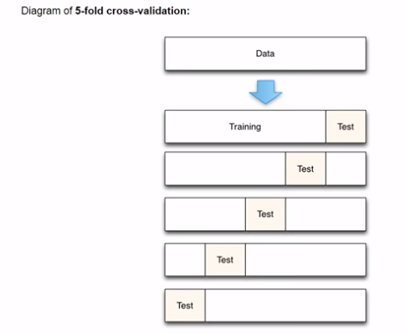

Создадим переменную 'X', куда запишем таблицу с признаками за исключением целевого признака.

In [7]:
X = users_behavior.drop(["is_ultra"], axis=1)

Запишем целевой категориельный признак (целевой массив) в переменную 'y'.

In [8]:
y = users_behavior[["is_ultra"]]

Отведем под тестовую выборку 30% датасэта, а под обучающую - 70%.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12345)

Проверим получившиеся пропорции:

In [10]:
len(X_train) / len(X)

0.6997510889856876

In [11]:
len(y_test) / len(X)

0.3002489110143124

Теперь все готово для начала обучения. Нам необходимо решить задачу классификации. Для этого могут подойти алгоритмы:

1. логистическая регрессия;
2. деревья принятия решений;
3. наивный Байесовский классификатор;
4. K-ближайших соседей (KNN);
5. метод опорных векторов (SVM);
6. Бустинг и AdaBoost;
7. GradientBoostingClassifier (градиентный спуск).

## Построение ML моделей

### Логистическая регрессия

Логистическая регрессия (или логит-регрессия) является широко используемой статистической моделью, которая использует логистическую функцию для моделирования зависимости выходной переменной от набора входных в случае, когда первая является бинарной.

Это разновидность множественной регрессии, общее назначение которой состоит в анализе связи между несколькими независимыми переменными (называемыми также регрессорами или предикторами) и зависимой переменной. Регрессия в общем виде применяется, когда входные и выходная переменные непрерывные. А логистическая регрессия лучшим образом подходит, когда выходная переменная принимает только два значения.

In [12]:
model_log_regr = LogisticRegression()

In [13]:
X_train_logregr = X_train.drop(["minutes"], axis=1)

Для подбора наилучшей модели воспользуемся GridSearchCV, который, перебирая все заданные параметры, выбирает те, за счет которых обеспечивается наибольшая точность модели. Создадим переменную с набором параметров, после чего обучим модель.

In [14]:
param_grid = [
    {'penalty' : ['l2', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'random_state': [12345]},
]

In [15]:
log_regr_clf = GridSearchCV(model_log_regr, param_grid=param_grid, cv=5, n_jobs=-1)

In [17]:
log_regr_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'penalty': ['l2', 'none'], 'random_state': [12345],
                          'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Модель обучена, оценим accuracy (доля правильных ответов), а также посмотрим, какие параметры были выбраны в качестве наилучших.

In [18]:
log_regr_clf.score(X_test, y_test)

0.7564766839378239

In [19]:
log_regr_clf.best_params_

{'penalty': 'l2', 'random_state': 12345, 'solver': 'newton-cg'}

Accuracy модели на тестовых данных составляет 0,7565. Этого достаточно для выполнения задания, однако, протестируем также другие алгоритмы и попробуем улучшить точность.

### Деревья принятия решений

Существуют несколько алгоритмов, связанных с деревом решений, которые решают задачи классификации: DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier, причем, последние два относятся к так называемым ансамблям - алгоритмам, которые состоят из нескольких алгоритмов машинного обучения, а процесс построения ансамбля называется ансамблированием (ensemble learning).

#### DecisionTreeClassifier

Для начала построим обычный DecisionTreeClassifier, а также визуализируем процесс обучения и посмотрим, как глубина дерева влияет на точность модели для тренировочной выборки, валидационной и тестовой.

Дерево решений — это метод представления решающих правил в иерархической структуре, состоящей из элементов двух типов — узлов (node) и листьев (leaf). В узлах находятся решающие правила и производится проверка соответствия примеров этому правилу по какому-либо атрибуту обучающего множества.

В простейшем случае, в результате проверки, множество примеров, попавших в узел, разбивается на два подмножества, в одно из которых попадают примеры, удовлетворяющие правилу, а в другое — не удовлетворяющие.

Обучим дерево решений на тренировочном сете.

In [20]:
max_depth_values = range(1, 100)

Создадим пустой датафрэйм, куда будем записывать значения accuracy.

In [21]:
dt_cross_val_scores = pd.DataFrame()

In [22]:
for max_depth in max_depth_values:
    dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=12345)
    dt_clf.fit(X_train, y_train)
    train_score = dt_clf.score(X_train, y_train)
    test_score = dt_clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(dt_clf, X_train, y_train, cv=5).mean()
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': [train_score],
                                   'test_score': [test_score],
                                   'cross_val_score': [mean_cross_val_score]})
    dt_cross_val_scores = dt_cross_val_scores.append(temp_score_data)

In [23]:
dt_cross_val_scores.head()

,max_depth,train_score,test_score,cross_val_score
0,1,0.755447,0.746114,0.754568
0,2,0.785238,0.781347,0.779466
0,3,0.801690,0.787565,0.795483
0,4,0.802134,0.788601,0.789254
0,5,0.812806,0.783420,0.785688


In [24]:
dt_cross_val_scores_long = pd.melt(dt_cross_val_scores, id_vars=['max_depth'], value_vars=['train_score', 'test_score', 'cross_val_score'],
                          var_name='type', value_name='score')

In [25]:
dt_cross_val_scores_long.head()

,max_depth,type,score
0,1,train_score,0.755447
1,2,train_score,0.785238
2,3,train_score,0.801690
3,4,train_score,0.802134
4,5,train_score,0.812806


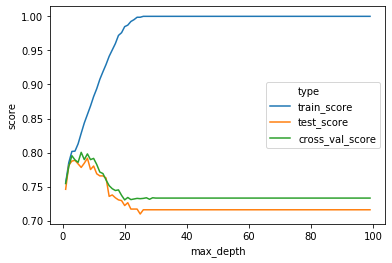

In [26]:
sns.lineplot(x="max_depth", y="score", hue="type", data=dt_cross_val_scores_long)

In [27]:
dt_cross_val_scores_long.query("type == 'cross_val_score'").head(20)

,max_depth,type,score
198,1,cross_val_score,0.754568
199,2,cross_val_score,0.779466
200,3,cross_val_score,0.795483
201,4,cross_val_score,0.789254
202,5,cross_val_score,0.785688
203,6,cross_val_score,0.800370
204,7,cross_val_score,0.789692
205,8,cross_val_score,0.798137
206,9,cross_val_score,0.789696
207,10,cross_val_score,0.791478


Наибольшая точность на кросс-валидации достигается при значении глубины дерева 6. Обучим и протестируем дерево решений с этим параметром.

In [29]:
best_dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=12345)

In [30]:
best_dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=12345, splitter='best')

In [31]:
best_dt_clf.score(X_test, y_test)

0.778238341968912

Мы получили более приемлимый результат, нежели с помощью логистической регрессии, accuracy равна 0,78 - в 78% случаев модель выдаёт корректный результат.

#### RandomForestClassifier

Random Forest, или же случайный лес, является улучшенной версией дерева решений, т.к. включает в себя множетсво деревьев решений, в результате чего выбирается то, которое показало наилучший результат. Обучим модель Random Forest.

In [32]:
model_rfc = RandomForestClassifier()

In [33]:
param_grid = [
    {'n_estimators' : [500],
    'criterion' : ['gini', 'entropy'],
    'random_state': [12345],
    'max_depth': range(5, 12)}
]

In [34]:
model_rfc_clf = GridSearchCV(model_rfc, param_grid=param_grid, cv=5, n_jobs=-1)

In [35]:
model_rfc_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

Модель обучена, оценим accuracy (доля правильных ответов), а также посмотрим, какие параметры были выбраны в качестве наилучших.

In [36]:
model_rfc_clf.score(X_test, y_test)

0.8072538860103627

In [37]:
model_rfc_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'n_estimators': 500,
 'random_state': 12345}

Показатель accuracy равен 0,807, следовательно, в 80,7% случаев модель будет давать корректные предсказания. Этот результат пока превосходит результаты предыдущих моделей.

#### ExtraTreesClassifier

ExtraTreesClassifier является классификатором, построенным по аналогии с случайным лесом. Разница между случайным лесом и ET состоит в стратегии выбора разделения подвыборки в вершине дерева для фиксированного подмножества признаков. Случайный лес проверяет всевозможные варианты разбиений для каждого признака, тогда как ET выбирает лишь среди случайно выбранных по одному на признак разбиений.

Обучим на наших данных модель ExtraTreesClassifier.

In [38]:
param_grid = [
    {'n_estimators': [500],
     'max_depth': range(7, 15),
    'random_state': [12345],
    'bootstrap': [True]}
]

In [39]:
model_extra_trees = ExtraTreesClassifier()

In [40]:
model_extra_trees_clf = GridSearchCV(model_extra_trees, param_grid=param_grid, cv=5, n_jobs=-1)

In [41]:
model_extra_trees_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                            criterion='gini', max_depth=None,
                                            max_features='auto',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators='warn', n_jobs=None,
                                            oob_score=False, random_state=None,
                                            verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid=[{'bootstrap': [True], 'm

In [42]:
model_extra_trees_clf.score(X_test, y_test)

0.8103626943005181

In [43]:
model_extra_trees_clf.best_params_

{'bootstrap': True,
 'max_depth': 13,
 'n_estimators': 500,
 'random_state': 12345}

Алгоритм ExtraTreesClassifier покзал себя эффективнее, мы получили точность 0.81. И в целом, это хороший результат.

### Наивный байесовский классификатор

В основе NBC (Naïve Bayes Classifier) лежит теорема Байеса. Теорема Байеса позволяет переставить местами причину и следствие. Зная с какой вероятностью причина приводит к некоему событию, эта теорема позволяет расчитать вероятность того что именно эта причина привела к наблюдаемому событию.

Обучим модель байесовского классификатора.

In [44]:
model_NB = GaussianNB()

In [45]:
cross_val_score(model_NB, X_train, y_train, cv=5).mean()

0.7794709438894348

In [46]:
model_NB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [47]:
model_NB.score(X_test, y_test)

0.7927461139896373

На тестовом наборе данных мы получили точность 0.79.

### Метод K-ближайших соседей (KNN)

Метод k-ближайших соседей используется для решения задачи классификации. Он относит объекты к классу, которому принадлежит большинство из k его ближайших соседей в многомерном пространстве признаков. Это один из простейших алгоритмов обучения классификационных моделей. Число k — это количество соседних объектов в пространстве признаков, которые сравниваются с классифицируемым объектом. Иными словами, если k=5, то каждый объект сравнивается с 5-ю соседями.

In [48]:
model_neigh = KNeighborsClassifier(n_neighbors=10)

In [49]:
cross_val_score(model_neigh, X_train, y_train, cv=5).mean()

0.7590027517282665

In [50]:
model_neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [51]:
model_neigh.score(X_test, y_test)

0.7616580310880829

Алгоритм показал не столь высокую точность - всего 0.76.

### Метод опорных векторов (SVM)

Основная идея метода заключается в построении гиперплоскости, разделяющей объекты выборки оптимальным способом. Алгоритм работает в предположении, что чем больше расстояние (зазор) между разделяющей гиперплоскостью и объектами разделяемых классов, тем меньше будет средняя ошибка классификатора. 

Однако, прежде чем приступить к обучению модели, сначала выполним предобработку обучающей выборки - выполним стандартизацию, т.е. приведем данные к одному масштабу. Сделаем это с помощью функции make_pipeline.  Pipeline не ограничивается предварительной обработкой и классификацией; с его помощью можно объединить любое количество моделей. Например, можно создать конвейер, включающий в себя выделение признаков, отбор признаков, масштабирование и  классификацию, в  общей сложности четыре этапа.X_train

In [52]:
model_svm = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))

In [53]:
cross_val_score(model_svm, X_train, y_train, cv=5).mean()

0.8034759458345748

In [54]:
model_svm.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='auto',
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [55]:
model_svm.score(X_test, y_test)

0.8010362694300518

Посмотрим на матрицу корреляций. Возможно, наличие корреляции между какими-то признаками будет ухудшать точность модели.

In [56]:
X_train.corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.981952,0.159558,0.278045
minutes,0.981952,1.000000,0.158706,0.275009
messages,0.159558,0.158706,1.000000,0.191297
mb_used,0.278045,0.275009,0.191297,1.000000


Признак minutes очень сильно коррелирует с признаком calls. Попробуем построить модель на тренировочных данных и протестировать ее без признака calls.

In [57]:
cross_val_score(model_svm, X_train.drop(['calls'], axis=1), y_train, cv=5).mean()

0.8025840917732927

In [58]:
model_svm.fit(X_train.drop(['calls'], axis=1), y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='auto',
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [59]:
model_svm.score(X_test.drop(['calls'], axis=1), y_test)

0.8020725388601037

Точность на кросс-валидации немного уменьшилась, однако, в целом точность модели на тестовых данных немного увеличилась: с 0.801 до 0.8021.

### AdaBoost

AdaBoost можно использовать для повышения производительности алгоритмов машинного обучения. Он лучше всего работает со слабыми обучающими алгоритмами, поэтому такие модели могут достигнуть точности гораздо выше случайной при решении задачи классификации. Наиболее распространенными алгоритмами, используемыми с AdaBoost, являются одноуровневые деревья решений

Обучим AdaBoost для DecisionTreeClassifier

In [60]:
param_grid = [
    {'base_estimator': [DecisionTreeClassifier(max_depth=1)],
    'n_estimators': range(50, 100, 10),
     'algorithm': ['SAMME', 'SAMME.R'],
     'random_state': [12345]}
]

In [61]:
model_ab = AdaBoostClassifier()

In [62]:
model_ab_clf = GridSearchCV(model_ab, param_grid=param_grid, cv=5, n_jobs=-1)

In [63]:
model_ab_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=None),
             iid='warn', n_jobs=-1,
             param_grid=[{'algorithm': ['SAMME', 'SAMME.R'],
                          'base_estimator': [DecisionTreeClassifier(class_weight=None,
                                                                    criterion='gini',
                                                                    max_depth=1,
                                                                    max_features=None,
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                                            

In [64]:
model_ab_clf.score(X_test, y_test)

0.7823834196891192

In [65]:
model_ab_clf.best_params_

{'algorithm': 'SAMME',
 'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=None, splitter='best'),
 'n_estimators': 90,
 'random_state': 12345}

На тестовых значениях алгоритм показал точность 0,7824, т.е. в 78,24% случаев был получен правильный результат.

### GradientBoostingClassifier

Градиентный Бустинг работает последовательно добавляя к прошлым моделям новые так, чтобы исправлялись ошибки, допущенные предыдущими предикторами.
Градиентный Бустинг отличается от Адаптивного тем, что, в отличие от AdaBoost, изменяющего веса при каждой итерации, Градиентный пытается обучать новые модели по остаточной ошибке прошлых (двигаясь к минимуму функции потерь).

Цель - подобрать такой коэффициент, чтобы функция потерь - по-простому, разность между истинным ответом и предсказанием модели - стала минимальной, т.е. предсказание максимально приблизилось к истинному значению.

In [66]:
param_grid = [
    {'loss': ['deviance', 'exponential'],
     'criterion': ['friedman_mse', 'mse', 'mae'],
     'random_state': [12345],
     'max_features': ['auto', 'sqrt', 'log2']}
]

In [67]:
model_gbc = GradientBoostingClassifier()

In [68]:
model_gbc_clf = GridSearchCV(model_gbc, param_grid=param_grid, cv=5, n_jobs=-1)

In [69]:
model_gbc_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  random_state=None,

In [70]:
model_gbc_clf.score(X_test, y_test)

0.7989637305699482

In [71]:
model_gbc_clf.best_params_

{'criterion': 'friedman_mse',
 'loss': 'deviance',
 'max_features': 'sqrt',
 'random_state': 12345}

Модель градиентного бустинга показала точность 0,79896.

### Вывод

Мы обучили и протестировали полученные модели. Проранжируем модели в зависимости от полученной точности на тестовых выборках:

1.	ExtraTreesClassifier - 0.8104;
2.	RandomForestClassifier - 0.8073;
3.	Метод опорных векторов - 0.8010;
4.	AdaBoost - 0.7824;
5.	GradientBoostingClassifier - 0,7990;
6.	Наивный байесовский классификатор - 0.7927;
7.	Дерево решений - 0.7917;
8.	Метод K-ближайших соседей - 0.7617;
9.	Логистическая регрессия - 0.7565.

Все модели продемонстрировали примерно одинаковые результаты за исключением метода K-ближайших соседей и логистической регрессии, которые показали худшие результаты. Наилучшей моделью для данной задачи является ExtraTreesClassifier.

## Проверка модели на адекватность

Прежде чем использовать модель на практике, необходимо оценить адекватность модели. Для этого нужно доказать, что наша модель работает лучше, чем случайная. Для этого используются метрики качества:

* accuracy - доля правильных ответов;
* precision и recall - точность и полнота информации.
* ROC-кривая

У accuracy есть очевидный недостаток. Интерпретация на несбалансированных выборках может быть в корне не верна. Например, у нас 950 объектов принадлежат к классу 0, а 50 к классу 1. И мы написали алгоритм, который все объекты классифицирует как 0. По сути это бесполезный алгоритм, однако, его accuracy будет соответствовать 0.95, что можно ошибочно интерпретировать, как хороший результат.

Отчасти эту проблему решает использование метрик точности и полноты информации:
* TP — истино-положительное решение;
* TN — истино-отрицательное решение;
* FP — ложно-положительное решение;
* FN — ложно-отрицательное решение.

$$ Precision = \frac {TP}{TP+FP} $$

$$ Recall = \frac {TP}{TP+FN} $$

Однако, возникает необходимость объединить две метрики в одну, это можно осуществить с помощью ROC-кривых. ROC кривая показывает на графике, какая доля верных и ложных срабатываний. График начинается в точке (0, 0), а заканчивается в точке (1, 1) и в идеале (при идеальной разделимости выборки) пройдет через точку (1, 0), т.е. доля верных срабатываний равна 1, а ложных - 0.

Таким образом, чем больше площадь под кривой, тем лучше классификатор.

Построим ROC-кривые для трех лучших алгоритмов и сравним их оценки с оценкой accuracy.

In [72]:
y_predicted_prob = model_extra_trees_clf.predict_proba(X_test)

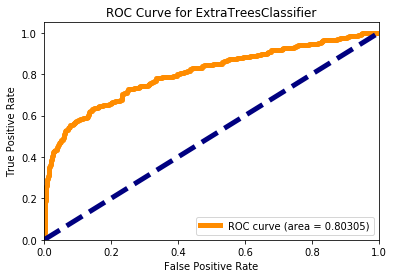

In [73]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
lw = 5
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ExtraTreesClassifier')
plt.legend(loc="lower right")
plt.show()

In [74]:
model_extra_trees_clf.score(X_test, y_test)

0.8103626943005181

Значения площади под ROC-кривой для алгоритма ExtraTreesClassifier получились немного ниже, нежели значение метрики accuracy: 0.80305 и 0.81036 соответственно.

Теперь построим ROC-кривую для случайного леса.

In [75]:
y_predicted_prob = model_rfc_clf.predict_proba(X_test)

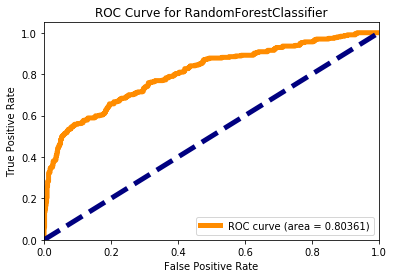

In [76]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
lw = 5
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForestClassifier')
plt.legend(loc="lower right")
plt.show()

In [77]:
model_rfc_clf.score(X_test, y_test)

0.8072538860103627

Алгоритм Random Forest имеет приблизительно равные значения accuracy и площади под ROC-кривой: 0.80725 и 0.80361 соответственно.

Выполним построение для метода опорных векторов.

In [78]:
y_predicted_prob = model_svm.predict_proba(X_test.drop(['calls'], axis=1))

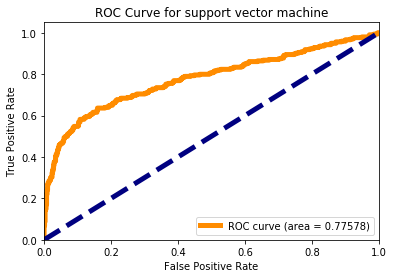

In [79]:
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
lw = 5
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for support vector machine')
plt.legend(loc="lower right")
plt.show()

In [80]:
model_svm.score(X_test.drop(['calls'], axis=1), y_test)

0.8020725388601037

Метод опорных векторов имеет accuracy модели 0,8021, а площадь ROC-кривой составляет 0,77578.

В случае, если бы ROC-кривая совпадала бы с пунктирной линией, классификатор можно было бы считать бесполезным, так как число истинно положительных ответов и ложно положительных было бы равным.

Мы убедились, что на практике оценка, полученная методом score (т.е. accuracy модели), может немного отличаться от оценки, которая получается за счет вычисления площади под ROC-кривой. ROC-кривая указывает на то, что наилучшим алгоритмом для решения данной задачи классификации является Random Forest, немного хуже с этой задачей справляется ExtraTreesClassifier, а с существенным отставанием - метод опорных векторов (SVM).

Также построим константную модель, которая всегда предсказывает наиболее часто встречающееся значение, после чего сравним эту модель с ExtraTreesClassifier.

In [81]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)

In [82]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=12345, strategy='most_frequent')

In [83]:
dummy_clf.predict(X_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Наиболее часто в качестве целевого признака встречался 0, поэтому модель для всех предсказаний использовала 0

In [84]:
dummy_clf.score(X_test, y_test)

0.6953367875647668

Точность такой модели существенно ниже, чем у алгоритмов, которые мы построили. Покажем также, что в случае предсказания моделью в качестве целевого признака значения 1, полученная оценка будет равна 1-0,695=0,305.

In [85]:
dummy_clf = DummyClassifier(strategy="constant", random_state=12345,  constant=[1])

In [86]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(constant=[1], random_state=12345, strategy='constant')

In [87]:
dummy_clf.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [88]:
dummy_clf.score(X_test, y_test)

0.30466321243523314

Мы получили, что точность константного классификатора с предсказаниями значений целевого признака в качестве 0 и 1 существенно ниже, нежели точность построенных алгоритмов. ExtraTreesClassifier имеет точность 0.81036 против 0.69533 константного классификатора.

### Вывод

Мы выяснили, что наилучшими разные метрики могут выдавать разные результаты. Выбор той или иной метрики зависит от конкретной задачи, ведь даже бесполезный алгоритм может обладать высокой accuracy, но при том не решать поставленной задачи.

Наибольшую площадь под ROC-кривой (0.80361) имеет алгоритм RandomForestClassifier, аccuracy (0.81036) - алгоритм ExtraTreesClassifier.

Константный классификатор ожидаемо спрогнозировал хуже, нежели RandomForestClassifier или ExtraTreesClassifier.

## Общий вывод

Мы построили и протестировали основные алгоритмы классификации. Наилучшим образом себя показали ансамбли деревьев - ExtraTreesClassifier и ExtraTreesClassifier, а логистическая регрессия, наоборот, оказалась наименее подходящим лгоритмом с низкой точностью.

На основании значения accuracy в качестве системы, которая способна проанализировать поведение клиентов и предложить пользователям новый тариф, принимаем алгоритм ExtraTreesClassifier.

Внедрение модели ExtraTreesClassifier будет полезным шагом, т.к. она проявила себя лучше, чем константный классификатор, который выдает в качестве прогноза наиболее часто встречающееся значение целевого признака.